# Santander Customer Transaction Prediction

### Cleaning our Data

### 1. Importing Libraries

In [1]:
##################################################
###### Import Libraries
##################################################

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier, plot_importance
from sklearn.model_selection import cross_val_score, GridSearchCV  #Additional scklearn functions

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 2000)

### 2. Importing Data

In [2]:
##################################################
###### Import Data
##################################################

path_train = 'santander/train.csv'
path_test = 'santander/test.csv'

# To Read files from AWS S3
import boto3
import io
s3 = boto3.client('s3')

obj_train = s3.get_object(Bucket='data-eml', Key=path_train)
obj_test = s3.get_object(Bucket='data-eml', Key=path_test)

train = pd.read_csv(io.BytesIO(obj_train['Body'].read()))
test = pd.read_csv(io.BytesIO(obj_test['Body'].read()))

print('Train Shape: %s\nTest Shape: %s'%(train.shape,test.shape))

Train Shape: (200000, 202)
Test Shape: (200000, 201)


In [3]:
train.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,5.7470,2.9252,3.1821,14.0137,0.5745,8.7989,14.5691,5.7487,-7.2393,4.2840,30.7133,10.5350,16.2191,2.5791,2.4716,14.3831,13.4325,-5.1488,-0.4073,4.9306,5.9965,-0.3085,12.9041,-3.8766,16.8911,11.1920,10.5785,0.6764,7.8871,4.6667,3.8743,-5.2387,7.3746,11.5767,12.0446,11.6418,-7.0170,5.9226,-14.2136,16.0283,5.3253,12.9194,29.0460,-0.6940,5.1736,-0.7474,14.8322,11.2668,5.3822,2.0183,10.1166,16.1828,4.9590,2.0771,-0.2154,8.6748,9.5319,5.8056,22.4321,5.0109,-4.7010,21.6374,0.5663,5.1999,8.8600,43.1127,18.3816,-2.3440,23.4104,6.5199,12.1983,13.6468,13.8372,1.3675,2.9423,-4.5213,21.4669,9.3225,16.4597,7.9984,-1.7069,-21.4494,6.7806,11.0924,9.9913,14.8421,0.1812,8.9642,16.2572,2.1743,-3.4132,9.4763,13.3102,26.5376,1.4403,14.7100,6.0454,9.5426,17.1554,14.1104,24.3627,2.0323,6.7602,3.9141,-0.4851,2.5240,1.5093,2.5516,15.5752,-13.4221,7.2739,16.0094,9.7268,0.8897,0.7754,4.2218,12.0039,13.8571,-0.7338,-1.9245,15.4462,12.8287,0.3587,9.6508,6.5674,5.1726,3.1345,29.4547,31.4045,2.8279,15.6599,8.3307,-5.6011,19.0614,11.2663,8.6989,8.3694,11.5659,-16.4727,4.0288,17.9244,18.5177,10.7800,9.0056,16.6964,10.4838,1.6573,12.1749,-13.1324,17.6054,11.5423,15.4576,5.3133,3.6159,5.0384,6.6760,12.6644,2.7004,-0.6975,9.5981,5.4879,-4.7645,-8.4254,20.8773,3.1531,18.5618,7.7423,-10.1245,13.7241,-3.5189,1.7202,-8.4051,9.0164,3.0657,14.3691,25.8398,5.8764,11.8411,-19.7159,17.5743,0.5857,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,8.0851,-0.4032,8.0585,14.0239,8.4135,5.4345,13.7003,13.8275,-15.5849,7.8000,28.5708,3.4287,2.7407,8.5524,3.3716,6.9779,13.8910,-11.7684,-2.5586,5.0464,0.5481,-9.2987,7.8755,1.2859,19.3710,11.3702,0.7399,2.7995,5.8434,10.8160,3.6783,-11.1147,1.8730,9.8775,11.7842,1.2444,-47.3797,7.3718,0.1948,34.4014,25.7037,11.8343,13.2256,-4.1083,6.6885,-8.0946,18.5995,19.3219,7.0118,1.9210,8.8682,8.0109,-7.2417,1.7944,-1.3147,8.1042,1.5365,5.4007,7.9344,5.0220,2.2302,40.5632,0.5134,3.1701,20.1068,7.7841,7.0529,3.2709,23.4822,5.5075,13.7814,2.5462,18.1782,0.3683,-4.8210,-5.4850,13.7867,-13.5901,11.0993,7.9022,12.2301,0.4768,6.8852,8.0905,10.9631,11.7569,-1.2722,24.7876,26.6881,1.8944,0.6939,-13.6950,8.4068,35.4734,1.7093,15.1866,2.6227,7.3412,32.0888,13.9550,13.0858,6.6203,7.1051,5.3523,8.5426,3.6159,4.1569,3.0454,7.8522,-11.5100,7.5109,31.5899,9.5018,8.2736,10.1633,0.1225,12.5942,14.5697

In [4]:
# Be aware of the column's position!!!
test.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_68,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,8.8100,-2.0248,-4.3554,13.9696,0.3458,7.5408,14.5001,7.7028,-19.0919,15.5806,16.1763,3.7088,18.8064,1.5899,3.0654,6.4509,14.1192,-9.4902,-2.1917,5.7107,3.7864,-1.7981,9.2645,2.0657,12.7753,11.3334,8.1462,-0.0610,3.5331,9.7804,8.7625,-15.6305,18.8766,11.2864,11.8362,13.3680,-31.9891,12.1776,8.7714,17.2011,16.8508,13.0534,14.4069,-4.8525,7.3213,-0.5259,16.6365,19.3036,6.4129,-5.3948,9.3269,11.9314,-3.5750,-0.7706,0.8705,6.9282,2.8914,5.9744,17.4851,5.0125,-1.4230,33.3401,0.8018,-4.7906,30.2708,26.8339,21.7205,7.3075,14.0810,3.1192,17.4265,9.4883,16.9060,14.5117,10.0276,-0.9706,20.4588,4.7945,20.4160,13.1633,7.9307,-7.6509,7.0834,15.2324,10.1416,5.9156,-0.5775,5.7600,30.3238,2.1251,1.8585,-9.2198,17.3089,30.9548,1.4918,12.8721,3.4902,8.2856,11.9794,14.0176,15.0763,3.7662,6.0426,4.4243,14.1799,2.0921,1.5493,3.2206,0.0172,-6.6602,8.4785,42.0248,11.4164,0.4564,9.4006,0.9685,12.4929,14.1240,4.0388,-4.4442,16.6684,12.5380,0.9205,10.5998,7.5147,-4.1748,-0.4824,10.5267,17.7547,-6.5226,-2.5502,-5.1547,-2.1246,19.8319,13.0752,9.2275,3.0213,11.6793,-11.6827,4.1017,5.2954,18.7741,9.8892,7.5219,14.9745,18.9880,1.0842,11.9125,-4.5103,16.1361,11.0067,5.9232,5.4113,3.8302,5.7380,-8.6105,22.9530,2.5531,-0.2836,4.3416,5.1855,4.2603,1.6779,29.0849,8.4685,18.1317,12.2818,-0.6912,10.2226,-5.5579,2.2926,-4.5358,10.3903,-15.4937,3.9697,31.3521,-1.1651,9.2874,-23.5705,13.2643,1.6591,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,5.9739,-1.3809,-0.3310,14.1129,2.5667,5.4988,14.1853,7.0196,4.6564,29.1609,0.0910,12.1469,3.1389,5.2578,2.4228,16.2064,13.5023,-5.2341,-3.6648,5.7080,2.9965,-10.4720,11.4938,-0.9660,15.3445,10.6361,0.8966,6.7428,2.3421,12.8678,-1.5536,10.0309,3.1337,10.5742,11.7664,2.1782,-41.1924,13.5322,-17.3834,6.3806,12.5589,11.6887,25.3930,1.5776,6.8481,8.7348,16.4239,21.7056,6.9345,1.6678,9.5249,5.3383,-18.7083,1.3382,-1.7401,5.8398,3.1051,4.4307,16.0005,5.0306,-7.3365,12.2806,0.6992,-0.7772,21.5123,6.7803,18.1896,6.9388,22.1336,6.3755,13.1525,1.9772,14.0406,6.6904,9.9732,-11.5679,20.4525,9.4951,9.6343,8.1252,2.6059,-17.4201,7.1848,15.3484,10.6522,5.9897,0.3392,10.3516,29.8204,1.9998,-1.4166,-1.7257,15.4712,35.6020,1.6570,13.0783,2.7752,6.4986,4.6835,13.7963,17.7261,1.7375,5.5689,3.6609,8.9725,4.1159,1.0693,2.0234,8.2760,-6.8610,0.2780,17.0488,11.6704,3.1215,8.5093,5.6367,12.0099,14.2372,-

### 3. Missing Values

In [5]:
##################################################
###### Missing Values
##################################################

def missing(df):
    num_empty_cols = 0
    columns = df.columns.tolist()
    for col in columns:
        if df[col].isnull().sum() > 0:
            print(col)
            num += 1
    print('Number of empty Columns in this Dataset: %s'%(num_empty_cols))   
    
missing(train)
missing(test)

Number of empty Columns in this Dataset: 0
Number of empty Columns in this Dataset: 0


### 4. Type Columns

In [6]:
object_type = []
for k,i in enumerate(train.columns.values.tolist()):
    if train[i].dtypes == 'object':
        #print(k,i,train[i].isnull().sum()/len(train))
        object_type.append(i)
        print(i)
len(object_type)

ID_code


1

In [7]:
object_type = []
for k,i in enumerate(test.columns.values.tolist()):
    if test[i].dtypes == 'object':
        #print(k,i,train[i].isnull().sum()/len(train))
        object_type.append(i)
        print(i)
len(object_type)

ID_code


1

In [8]:
##################################################
###### Drop Object Columns
##################################################

test_code = test['ID_code']

def drop_object_columns(df_train,df_test):
    object_type_train = []
    for i in df_train.columns.values.tolist():
        if df_train[i].dtypes == 'object':
            object_type_train.append(i)
    df_train.drop(columns=object_type_train, inplace=True)
    df_test.drop(columns=object_type_train, inplace=True)
    object_type_test = []
    for i in df_test.columns.values.tolist():
        if df_test[i].dtypes == 'object':
            object_type_test.append(i)
    df_train.drop(columns=object_type_test, inplace=True)
    df_test.drop(columns=object_type_test, inplace=True)
    print('***********************************************************')
    print('Train Shape: %s\nTest Shape: %s'%(df_train.shape,df_test.shape))
    print('***********************************************************')
    null_train = df_train.isnull().sum().sum()/(df_train.shape[0]*df_train.shape[1])
    null_test = df_test.isnull().sum().sum()/(df_test.shape[0]*df_test.shape[1])
    print('%MissingValuesTrain:',round(null_train,2))
    print('%MissingValuesTest:',round(null_test,2))
    
drop_object_columns(train,test)

***********************************************************
Train Shape: (200000, 201)
Test Shape: (200000, 200)
***********************************************************
%MissingValuesTrain: 0.0
%MissingValuesTest: 0.0


### 5. Zero Variation Columns

In [9]:
##################################################
###### Drop Columns with ZERO VARIATION
##################################################

# If there is a column with a constant value you can't learn of it, you must drop that column
def drop_zero_std_columns(df_train,df_test):
    zero_std_list_train = []
    for i in df_train.columns.values.tolist():
        if df_train[i].std() == 0:
            zero_std_list_train.append(i) 
    df_train.drop(columns=zero_std_list_train, inplace=True)
    df_test.drop(columns=zero_std_list_train, inplace=True)
    zero_std_list_test = []
    for i in df_test.columns.values.tolist():
        if df_test[i].std() == 0:
            zero_std_list_test.append(i) 
    df_train.drop(columns=zero_std_list_test, inplace=True)
    df_test.drop(columns=zero_std_list_test, inplace=True)
    print('***********************************************************')
    print('Train Shape: %s\nTest Shape: %s'%(df_train.shape,df_test.shape))
    print('***********************************************************')
    null_train = df_train.isnull().sum().sum()/(df_train.shape[0]*df_train.shape[1])
    null_test = df_test.isnull().sum().sum()/(df_test.shape[0]*df_test.shape[1])
    print('%MissingValuesTrain:',round(null_train,2))
    print('%MissingValuesTest:',round(null_test,2))

drop_zero_std_columns(train,test)

***********************************************************
Train Shape: (200000, 201)
Test Shape: (200000, 200)
***********************************************************
%MissingValuesTrain: 0.0
%MissingValuesTest: 0.0


### 6. Low Variation Columns

In [10]:
##################################################
###### Drop Columns with very LOW VARIATION
##################################################

def drop_low_std_columns(df_train,df_test,min_std=0.05):
    low_std_list_train = []
    for i in df_train.columns.values.tolist():
        if  df_train[i].std() < min_std:
            print(i)
            low_std_list_train.append(i)
    df_train.drop(columns=low_std_list_train, inplace=True)
    df_test.drop(columns=low_std_list_train, inplace=True)  
    low_std_list_test = []
    for i in df_test.columns.values.tolist():
        if  df_test[i].std() < min_std:
            print(i)
            low_std_list_test.append(i)
    df_train.drop(columns=low_std_list_test, inplace=True)
    df_test.drop(columns=low_std_list_test, inplace=True)
    print('***********************************************************')
    print('Train Shape: %s\nTest Shape: %s'%(df_train.shape,df_test.shape))
    print('***********************************************************')
    null_train = df_train.isnull().sum().sum()/(df_train.shape[0]*df_train.shape[1])
    null_test = df_test.isnull().sum().sum()/(df_test.shape[0]*df_test.shape[1])
    print('%MissingValuesTrain:',round(null_train,2))
    print('%MissingValuesTest:',round(null_test,2))

drop_low_std_columns(train,test,0.05)

var_68
***********************************************************
Train Shape: (200000, 200)
Test Shape: (200000, 199)
***********************************************************
%MissingValuesTrain: 0.0
%MissingValuesTest: 0.0


### 7. Numeric Type

In [11]:
# All my data have numeric type!
print('*****Train*****\n',train.dtypes.value_counts()) 
print('*****Test*****\n',test.dtypes.value_counts())

*****Train*****
 float64    199
int64        1
dtype: int64
*****Test*****
 float64    199
dtype: int64


### 8. Resampling

In [12]:
def check_balance(df,target):
    check=[]
    # written by MJ Bahmani for binary target
    print('size of data is:',df.shape[0] )
    for i in [0,1]:
        print('###### Target {} ######'.format(i))
        print(df[target].value_counts()[i]/df.shape[0]*100,'%')
        print(df[target].value_counts()[i])

In [13]:
check_balance(train,'target')

size of data is: 200000
###### Target 0 ######
89.95100000000001 %
179902
###### Target 1 ######
10.049 %
20098


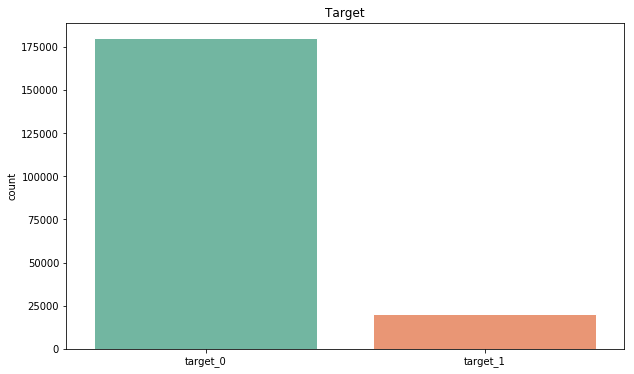

In [14]:
fig, ax = plt.subplots(1,1, figsize = (10,6))
sns.set()
g =sns.countplot(x='target',data=train, palette="Set2")
g.set(xticks=range(2), xticklabels=['target_0','target_1'])
plt.title('Target')
plt.xlabel('');
# fig = g.get_figure()
# fig.savefig("../images/target.png")

___These Data are unbalanced!!!___

Target_0:  179902 
Target_1:  20098
Random under-sampling:
0    22098
1    20098
Name: target, dtype: int64


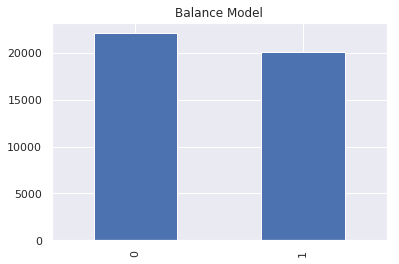

In [15]:
# Class count
count_class_0, count_class_1 = train['target'].value_counts()
print('Target_0: ',count_class_0, '\nTarget_1: ', count_class_1)
# Divide by class
train_class_0 = train[train['target'] == 0]
train_class_1 = train[train['target'] == 1]

train_class_0_under = train_class_0.sample(count_class_1+2000,random_state=1234)
train_balance = pd.concat([train_class_0_under, train_class_1], axis=0)

print('Random under-sampling:')
print(train_balance['target'].value_counts())

train_balance['target'].value_counts().plot(kind='bar', title='Balance Model');

### 9. Train Test Split

In [16]:
##################################################
###### Train and Test: Features and Target 
##################################################
# X:Features y:Target
y = train_balance['target']
X = train_balance.drop(columns=['target'])
# Reorder Index
test_ = test.reindex(columns=X.columns)
print('X:',X.shape,'y:',y.shape,'test:',test_.shape)

X: (42196, 199) y: (42196,) test: (200000, 199)


In [17]:
X.head()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,var_10,var_11,var_12,var_13,var_14,var_15,var_16,var_17,var_18,var_19,var_20,var_21,var_22,var_23,var_24,var_25,var_26,var_27,var_28,var_29,var_30,var_31,var_32,var_33,var_34,var_35,var_36,var_37,var_38,var_39,var_40,var_41,var_42,var_43,var_44,var_45,var_46,var_47,var_48,var_49,var_50,var_51,var_52,var_53,var_54,var_55,var_56,var_57,var_58,var_59,var_60,var_61,var_62,var_63,var_64,var_65,var_66,var_67,var_69,var_70,var_71,var_72,var_73,var_74,var_75,var_76,var_77,var_78,var_79,var_80,var_81,var_82,var_83,var_84,var_85,var_86,var_87,var_88,var_89,var_90,var_91,var_92,var_93,var_94,var_95,var_96,var_97,var_98,var_99,var_100,var_101,var_102,var_103,var_104,var_105,var_106,var_107,var_108,var_109,var_110,var_111,var_112,var_113,var_114,var_115,var_116,var_117,var_118,var_119,var_120,var_121,var_122,var_123,var_124,var_125,var_126,var_127,var_128,var_129,var_130,var_131,var_132,var_133,var_134,var_135,var_136,var_137,var_138,var_139,var_140,var_141,var_142,var_143,var_144,var_145,var_146,var_147,var_148,var_149,var_150,var_151,var_152,var_153,var_154,var_155,var_156,var_157,var_158,var_159,var_160,var_161,var_162,var_163,var_164,var_165,var_166,var_167,var_168,var_169,var_170,var_171,var_172,var_173,var_174,var_175,var_176,var_177,var_178,var_179,var_180,var_181,var_182,var_183,var_184,var_185,var_186,var_187,var_188,var_189,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
82075,12.3444,3.2356,12.2062,6.1900,12.4564,-18.6605,5.1379,22.5078,0.7094,7.9825,-3.1805,-0.8972,14.0646,4.1096,9.1814,14.6115,6.5268,3.4570,-1.9848,13.2157,17.4169,23.2539,0.8968,3.8269,9.7344,13.3675,-10.9227,-0.9091,5.4273,4.4600,-12.1517,7.3868,1.9967,13.3814,12.1259,7.4540,5.9272,5.3454,13.4086,3.4369,-7.1908,1.3228,11.1641,11.4942,9.8316,12.3114,8.7932,-16.1441,9.6214,18.8868,11.9937,16.3550,4.3413,6.7555,10.8177,17.4861,15.7161,4.2340,2.0578,9.2172,10.4597,-3.7035,2.9300,6.0380,6.0480,1.6946,6.5903,17.5211,-3.6641,25.6457,0.8056,2.2264,24.1918,26.4430,22.4244,21.8107,22.6867,6.1804,13.5354,2.3057,14.8765,-2.7880,0.7523,-5.1968,13.6734,9.9005,22.8542,12.1735,6.1435,5.8517,7.1198,18.6451,9.7506,12.1841,-0.9749,27.7463,10.2871,2.5829,-4.0072,13.6594,18.3914,21.2716,1.5129,9.8380,4.1739,5.5994,4.2309,14.0698,18.9704,3.6752,8.9492,2.3286,3.4749,2.0730,2.2490,2.6359,8.3478,7.4622,0.0088,43.0629,9.4320,-2.7688,16.0028,5.3798,12.3964,13.4707,2.9465,-2.9163,10.7466,11.6906,0.8143,6.4684,6.9790,-13.0765,13.1389,32.6450,25.0647,-2.1482,-3.9155,1.8202,4.2195,10.1968,9.9144,7.6529,3.2058,8.7031,-6.4370,4.3462,-7.1121,16.5344,6.3148,9.4963,16.6464,0.5738,1.2670,14.9713,-8.2269,2.0639,15.9732,36.7893,5.6050,4.7851,17.2343,-8.1268,20.7063,3.6366,-5.1920,5.6746,6.1712,-1.8061,5.7626,14.7289,-1.8312,33.0799,10.8009,-1.6065,12.5254,0.8769,6.1865,-0.3775,9.8867,0.1977,18.3824,15.6032,3.6571,8.7817,-26.3617,7.6784,2.0351,4.2322,5.9767,0.6406,-0.5855,12.7594,0.7745,-4.1662,10.1437,16.5096,16.3265
180524,8.1598,-9.2205,10.8822,6.1717,11.6367,-5.5769,5.7872,13.2323,-0.3177,7.9549,1.5910,-4.7859,14.1592,13.6309,10.4492,14.2706,5.9442,-2.2774,28.5202,17.1886,9.6691,15.4849,2.8458,3.2830,6.4891,13.5093,-5.7747,0.3485,4.0357,4.0349,-4.4346,11.4456,-4.2974,15.5516,11.5404,6.3624,7.5926,5.9275,4.5670,1.4105,3.8077,9.4921,10.8779,11.3637,10.3768,-27.8095,11.4422,-16.8451,6.1315,20.0765,13.2933,8.9078,-6.5920,6.7111,3.4113,5.3812,18.2174,5.1232,7.6455,9.8340,18.5352,-16.0839,2.2831,2.1884,4.6543,-0.8486,6.1980,8.6932,-6.5822,27.0839,0.9859,2.6192,27.0668,28.8780,9.6568,8.9520,12.2241,4.5196,14.8280,14.2119,15.5915,-12.0210,-11.2612,-7.8047,12.0280,20.5814,11.7612,6.4664,7.9033,-32.9147,6.9711,23.4670,10.9556,15.3760,0.7004,20.5035,23.8063,2.7244,-1.0943,-8.9553,9.7204,25.4706,1.6335,9.5522,4.1433,4.4036,14.8235,14.0166,19.1425,3.0015,6.2991,5.4773,12.4363,2.6706,5.5177,3.1117,1.2368,1.0417,4.6466,16.5282,11.9160,-1.3662,7.1121,5.7975,12.7155,12.0888,2.6555,-2.7675,14.5541,12.9454,0.8340,8.6093,6

In [18]:
y.head()

82075     0
180524    0
94705     0
155510    0
57554     0
Name: target, dtype: int64

In [19]:
##################################################
###### Splitting between train and test 
##################################################

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state = 4) 

### 10. Model

In [24]:
##################################################
###### XGBoost Model 
##################################################

# Verbose True writes all the steps

xgb = XGBClassifier(learning_rate= 0.01,n_estimators= 1000 ,max_depth= 3,subsample = 0.8,colsample_bytree = 1,gamma = 1,seed = 45)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time xgb.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.610167	validation_0-error:0.403832	validation_1-auc:0.607183	validation_1-error:0.403665
[1]	validation_0-auc:0.627697	validation_0-error:0.405559	validation_1-auc:0.621418	validation_1-error:0.409116
[2]	validation_0-auc:0.640407	validation_0-error:0.395842	validation_1-auc:0.635688	validation_1-error:0.39308
[3]	validation_0-auc:0.639306	validation_0-error:0.39222	validation_1-auc:0.634953	validation_1-error:0.390473
[4]	validation_0-auc:0.638891	validation_0-error:0.390663	validation_1-auc:0.634856	validation_1-error:0.388893
[5]	validation_0-auc:0.641087	validation_0-error:0.390629	validation_1-auc:0.638079	validation_1-error:0.388261
[6]	validation_0-auc:0.641786	validation_0-error:0.390527	validation_1-auc:0.636923	validation_1-error:0.391737
[7]	validation_0-auc:0.642463	validation_0-error:0.390832	validation_1-auc:0.637896	validation_1-error:0.391895
[8]	validation_0-auc:0.647527	validation_0-error:0.391306	validation_1-auc:0.643303	validation_1-error:0.3

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=45, silent=True,
       subsample=0.8)

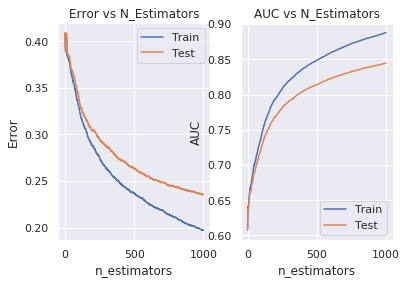

In [25]:
# Optimising N_ESTIMATOR

results = xgb.evals_result()

fig = plt.figure()
plt.subplot(1,2,1)
plt.plot(results['validation_0']['error'],label='Train')
plt.plot(results['validation_1']['error'],label='Test')
plt.title('Error vs N_Estimators')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(results['validation_0']['auc'],label='Train')
plt.plot(results['validation_1']['auc'],label='Test')
plt.title('AUC vs N_Estimators')
plt.xlabel('n_estimators')
plt.ylabel('AUC');
plt.legend()
plt.grid(True)

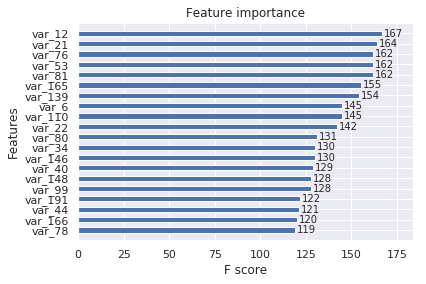

In [26]:
plot_importance(xgb,height=0.5,max_num_features=20);

In [29]:
##################################################
###### XGBoost Model early stopping rounds
##################################################

# Early stopping enables you to specify a validation dataset and the number of iterations after which the algorithm should stop if the score on your validation dataset didn’t increase.

xgb2 = XGBClassifier(learning_rate= 0.01,n_estimators= 3000 ,max_depth= 3,subsample = 0.8,colsample_bytree = 1,gamma = 1,seed = 45)
eval_set = [(X_train, y_train), (X_test, y_test)]
eval_metric = ["auc","error"]
%time xgb2.fit(X_train, y_train,early_stopping_rounds=100 ,eval_metric=eval_metric, eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.610167	validation_0-error:0.403832	validation_1-auc:0.607183	validation_1-error:0.403665
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 100 rounds.
[1]	validation_0-auc:0.627697	validation_0-error:0.405559	validation_1-auc:0.621418	validation_1-error:0.409116
[2]	validation_0-auc:0.640407	validation_0-error:0.395842	validation_1-auc:0.635688	validation_1-error:0.39308
[3]	validation_0-auc:0.639306	validation_0-error:0.39222	validation_1-auc:0.634953	validation_1-error:0.390473
[4]	validation_0-auc:0.638891	validation_0-error:0.390663	validation_1-auc:0.634856	validation_1-error:0.388893
[5]	validation_0-auc:0.641087	validation_0-error:0.390629	validation_1-auc:0.638079	validation_1-error:0.388261
[6]	validation_0-auc:0.641786	validation_0-error:0.390527	validation_1-auc:0.636923	validation_1-error:0.391737
[7]	validation_0-auc:0.642463	validation_0-error:0.39083

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=1, learning_rate=0.01, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=3000,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=45, silent=True,
       subsample=0.8)

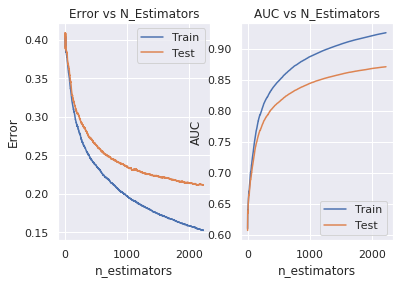

In [30]:
results2 = xgb2.evals_result()
fig = plt.figure()
plt.subplot(1,2,1)
plt.plot(results2['validation_0']['error'],label='Train')
plt.plot(results2['validation_1']['error'],label='Test')
plt.title('Error vs N_Estimators')
plt.xlabel('n_estimators')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(results2['validation_0']['auc'],label='Train')
plt.plot(results2['validation_1']['auc'],label='Test')
plt.title('AUC vs N_Estimators')
plt.xlabel('n_estimators')
plt.ylabel('AUC');
plt.legend()
plt.grid(True)

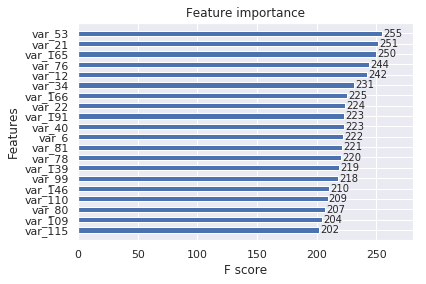

In [31]:
plot_importance(xgb2,height=0.5,max_num_features=20);

In [20]:
########################################################
###### Function to evaluate our model
########################################################
def auc(m, train, test): 
    return (metrics.roc_auc_score(y_train,m.predict_proba(train)[:,1]),
            metrics.roc_auc_score(y_test,m.predict_proba(test)[:,1]))

In [35]:
########################################################
###### Tune max_depth and min_child_weight n_Estimators
########################################################

#### Parameter Tuning ####
model = XGBClassifier()
param_dist = {"max_depth": [4,5],
              "min_child_weight" : [1],
              "n_estimators": [2124],
              "learning_rate": [0.01],
              "gamma":[0,1],
              "colsample_bytree":[1]}

grid_search = GridSearchCV(model,
                           param_grid=param_dist,
                           cv = 3, 
                           verbose=10,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

grid_search.best_estimator_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed: 47.7min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 54.1min remaining: 38.6min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 71.5min remaining: 23.8min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 84.3min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=2124,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [36]:
##################################################
###### Best Model: Training with X_train
##################################################

model = grid_search.best_estimator_

model.fit(X_train,y_train)

y_pred_prob = model.predict_proba(X_test)
y_pred = model.predict(X_test)

auc(model, X_train, X_test)

(0.9865260635810353, 0.8752440549215291)

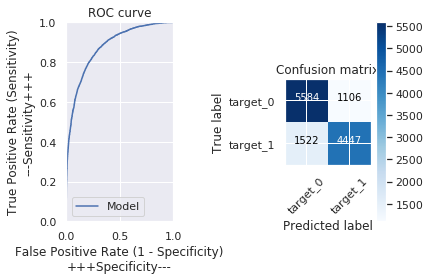

In [37]:
##################################################
###### ROC CURVE and CONFUSION MATRIX
##################################################

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob[:,1])
fig = plt.figure()
plt.subplot(1,2,1)
plt.plot(fpr, tpr,label='Model')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve')
plt.xlabel('False Positive Rate (1 - Specificity)\n+++Specificity---')
plt.ylabel('True Positive Rate (Sensitivity)\n---Sensitivity+++')
plt.legend()
plt.grid(True)

# From Scikit-Learn Documentation
cm = metrics.confusion_matrix(y_test, y_pred)
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.subplot(1,2,2)
plot_confusion_matrix(cm, classes=['target_0','target_1'],
                      title='Confusion matrix')

plt.show()  

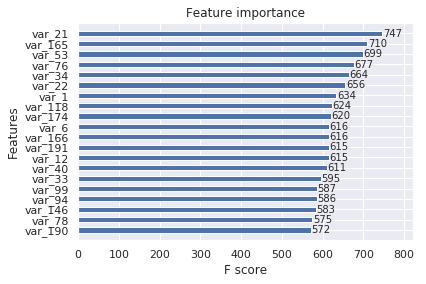

In [38]:
plot_importance(model,height=0.5,max_num_features=20);

In [21]:
##################################################
###### Best Model: Training with all the Data
##################################################

#model = grid_search.best_estimator_

model = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
        colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
        max_depth=5, min_child_weight=1, missing=None, n_estimators=2124,
        n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
        silent=True, subsample=1)

model.fit(X, y)

y_pred = model.predict_proba(test_)[:,1]

In [23]:
##################################################
###### Submission
##################################################

test['ID_code'] = test_code
test['target'] = y_pred
sub = test[['ID_code','target']]
sub.to_csv('./submission/submission_final.csv', index=None)